In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime

# Data Preprocessing

In [15]:
data = {}
with open('city_search.json', 'r') as f:
    js = json.load(f)
    session_id,unix_timestamp,cities = [],[],[]
    user_id,joining_date,country = [],[],[]
    for row in js:
        session_id.append(row['session_id'][0]) 
        unix_timestamp.append(row['unix_timestamp'][0]) 
        cities.append(row['cities'][0]) 
        user_id.append(row['user'][0][0]['user_id']) 
        joining_date.append(row['user'][0][0]['joining_date']) 
        country.append(row['user'][0][0]['country']) 
        
data['session_id'] = session_id
data['unix_timestamp'] = unix_timestamp
data['cities'] = cities
data['user_id'] = user_id
data['joining_date'] = joining_date
data['country'] = country

df = pd.DataFrame(data)

In [21]:
df['unix_timestamp'] = df['unix_timestamp'].apply(lambda x: datetime.fromtimestamp(x))
df['hour'] = df['unix_timestamp'].apply(lambda x: x.hour)
df['country'] = df['country'].apply(lambda x: "Unknown" if x == "" else x)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20022 entries, 0 to 20021
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   session_id      20022 non-null  object        
 1   unix_timestamp  20022 non-null  datetime64[ns]
 2   cities          20022 non-null  object        
 3   user_id         20022 non-null  int64         
 4   joining_date    20022 non-null  object        
 5   country         20022 non-null  object        
 6   hour            20022 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 1.1+ MB


In [32]:
df[df.country == "Unknown"].head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,hour
6,YOVUIM79SGS5Y,2015-09-25 17:04:47,"Montreal QC, Chicago IL",8831,2015-03-02,Unknown,17
7,SHXEY67QWKP9K,2015-05-16 16:48:24,"Calgary AB, New York NY",587,2015-03-16,Unknown,16
9,UY49RTVRX3GL7,2015-08-09 15:17:47,New York NY,5995,2015-03-21,Unknown,15
19,YQAEPPG214CNU,2015-08-16 16:29:20,"Toronto ON, New York NY",957,2015-03-30,Unknown,16
37,51H4C2DEYXG5D,2015-07-09 20:24:54,New York NY,5433,2015-03-05,Unknown,20


**One starting point to guess where is the missing country might be the time zone, since most people are active during the daytime and the distribution of the hour of the timestamp should fall under a bell shape.**

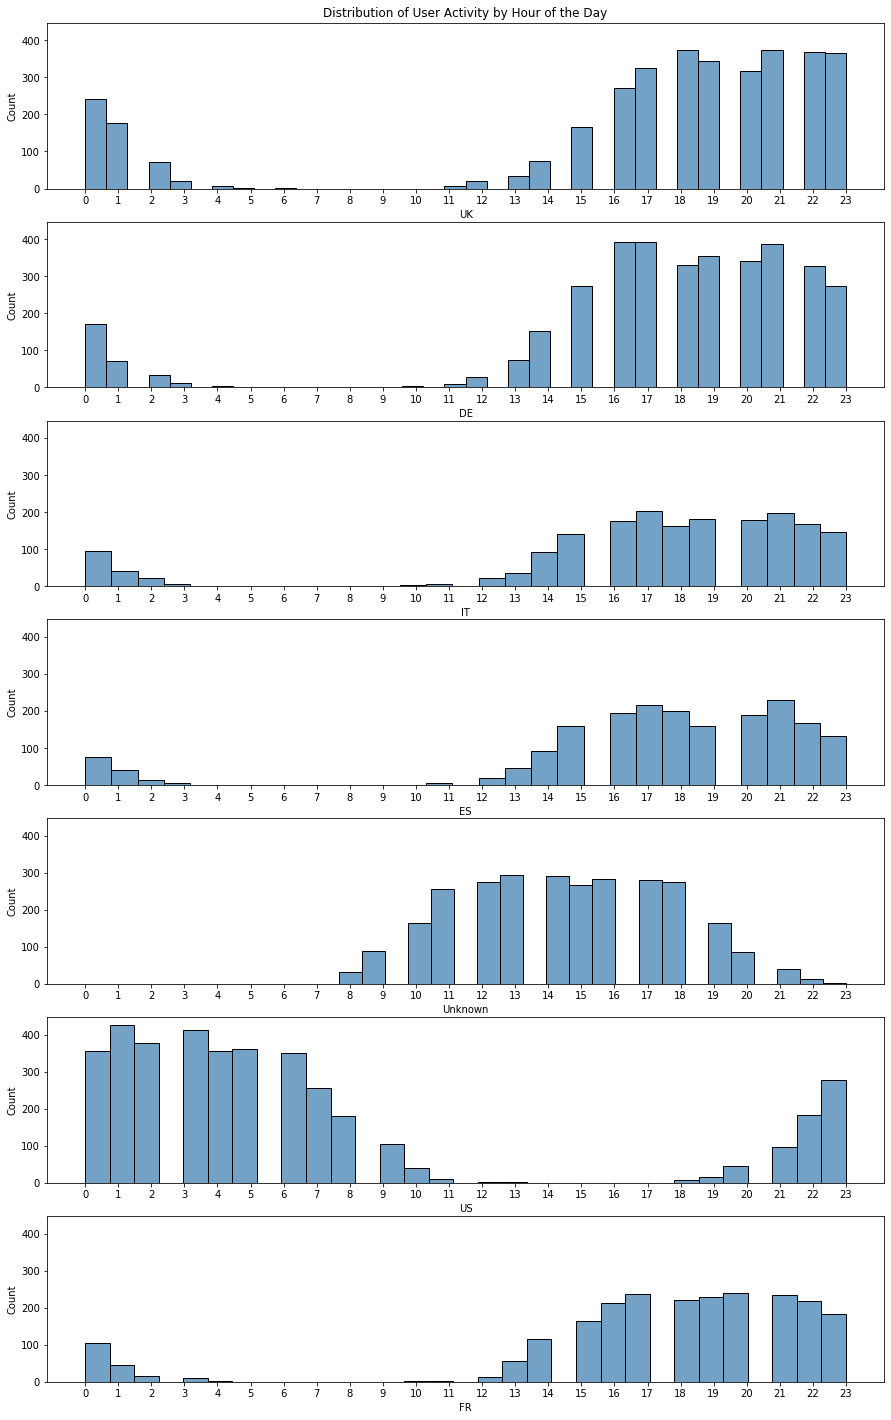

In [82]:
countries = df.country.unique()
fig, ax = plt.subplots(nrows=len(countries), figsize=(15, 25), sharey=True)
ax[0].set_title('Distribution of User Activity by Hour of the Day')

for i, c in enumerate(countries):
    piece = df[df.country==c]
    sns.histplot(data=piece, x='hour', ax=ax[i], color='steelblue')
    ax[i].set_xlabel(c)
    ax[i].set_xticks(range(24))

**Unsurprisingly, UK,FR,DE,IT and ES has a similar distribution while US and the missing one behaved differently. Therefore, the missing country is probably not in European or American continent. Based on the time differneces, the missing country is very likely to be located in the east Asia, China, Japan or South Korea is probably the missing one.**

# Analysis

## Cities that were often searched together

In [98]:
city_list = []

for x in df['cities'].unique():
    city_list.extend(x.split(','))
    
city_list = np.unique([x.strip() for x in city_list])

In [123]:
similar_cities = pd.DataFrame(index=city_list, columns=city_list, data=0)

for c in city_list:
    for i in city_list:
        similar_cities.loc[c, i] = df['cities'].apply(lambda x: 1 if c in x and i in x else 0).sum()

In [176]:
def get_similar_city(x):
    
    city = x.name
    top2 = x.sort_values(ascending=False).head(2)
    
    if top2.index[0] != city:
        return top2.index[0]
    else:
        return top2.index[1]


**According to the frequency of two cities that were searched together, below is the result of the similarities.**

In [179]:
similar_cities.apply(get_similar_city, axis=1).sample(20)

Miami FL             Jacksonville FL
Lincoln NE                Madison WI
Halifax NS                 Quebec QC
Greensboro NC            Montreal QC
Omaha NE                  Madison WI
Glendale AZ               Phoenix AZ
Sacramento CA            San Jose CA
London ON               Kitchener ON
Hialeah FL           Jacksonville FL
Raleigh NC             Chesapeake VA
OTTAWA ON                Montreal QC
Virginia Beach VA        New York NY
Fort Worth TX              Dallas TX
Jacksonville FL             Tampa FL
Boston MA                New York NY
Plano TX                   Dallas TX
Anaheim CA            Los Angeles CA
Norfolk VA               New York NY
Houston TX               New York NY
Oakland CA               San Jose CA
dtype: object

## Segmenting users

In [231]:
from geopy.geocoders import Nominatim
from geopy.distance import distance
geolocator = Nominatim(user_agent="your_app_name")

def get_trip_avg_distance(x):
    
    cities = [x.strip() for x in x.split(',')]
    if len(cities) == 1:
        distance_ = 0
    else:
        combos = list(combinations(cities, 2))
        distances = []
        for combo in combos:
            try:
                loc1 = geolocator.geocode(combo[0], country_codes='us|ca')[1]
                loc2 = geolocator.geocode(combo[1], country_codes='us|ca')[1]
            
                distances.append(distance(loc1, loc2).km)
            except:
                print(combo)
                distances.append(-1)
            
        distance_ = np.mean(distances)
    
    return distance_

In [238]:
df['avg_trip_distance'] = df['cities'].apply(get_trip_avg_distance)

In [239]:
df.head()

,session_id,unix_timestamp,cities,user_id,joining_date,country,hour,avg_trip_distance
0,X061RFWB06K9V,2015-09-17 23:28:28,"New York NY, Newark NJ",2024,2015-03-22,UK,23,14.282981
1,5AZ2X2A9BHH5U,2015-09-04 16:06:31,"New York NY, Jersey City NJ, Philadelphia PA",2853,2015-03-28,DE,16,86.946113
2,SHTB4IYAX4PX6,2015-08-29 18:18:10,San Antonio TX,10958,2015-03-06,UK,18,0.000000
3,JBRB8MZGTX3M4,2015-03-25 15:21:03,Edmonton AB,7693,2015-03-12,IT,15,0.000000
4,YJCMPURC2FL9C,2015-05-02 17:31:07,"Phoenix AZ, Houston TX",7506,2015-02-28,UK,17,1635.256569


**Assume that travlers visit cities that are within 1 hour of flight, which typically falls under the distance range of 300 to 500km. Therefore, setting 500km as a threshold might be a good way to saparate intentions.**

In [251]:
df['intention'] = df['avg_trip_distance'].apply(lambda x: "High Intent" if x <= 500 else "Low Intent")

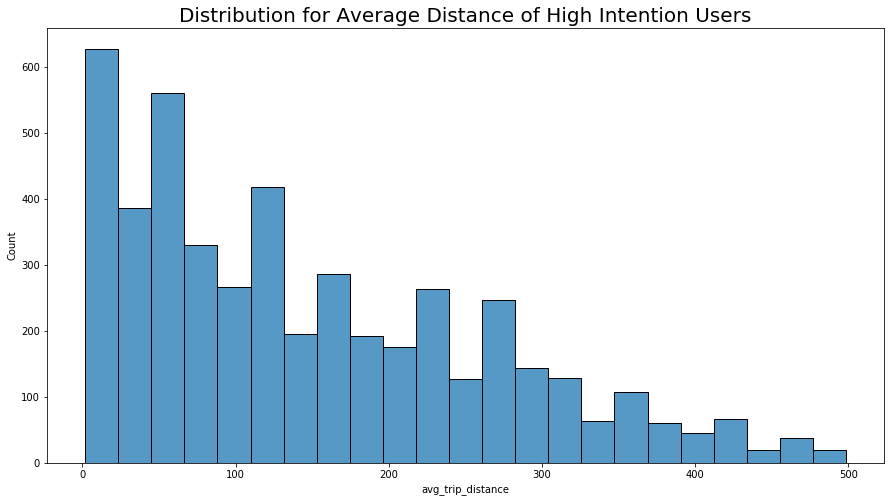

In [261]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.histplot(df.loc[(df['intention']=='High Intent')&(df['avg_trip_distance']!=0), 'avg_trip_distance'])
plt.title("Distribution for Average Distance of High Intention Users", fontsize=20);